A large part of a data scientist's job is to build models that try to learn patterns from existing data, and apply those patterns to new data. For many of our models, we can call `predict` and get a "point estimate" - or our best guess - at what the new value should be. Our models generally don't have a robust uncertainity associated with them: if I tell my model about the features of my house, its best prediction might be that my house is worth 340k, but it would be nice to know if the expected error on this is $\pm 10$k, $\pm 50$k, or even $\pm 100$k! It is difficult to make decisions if I don't know what my uncertainty looks like.

Statisticians face a similar problem called [_inference_](https://en.wikipedia.org/wiki/Statistical_inference), where they try to make a statement about the some property of the entire population (called a population _parameter_), but they only have access to a sample of the population. Statistics inference is the task of estimating those population parameters from the sample parameters. 

As a simple example, take trying to estimate the mean height $\mu$ of a population based on a sample of $N$ pepople. The best guess that you are able to make (a so-called "unbiased estimate") is to use the mean height $\bar{x}$ of your sample. We intuitively know that as the number of people in the sample $N$ gets larger, our sample estimate of the population mean ($\bar{x}$) should get closer to the population mean height ($\mu$). In short, we are more confident in large samples than small ones. For the specific problem of estimating a mean, the central limit theorem from statistics gives a nice way of estimating the uncertainty.

Our data scientist who wants to estimate the uncertainty in her model would probably have a similar intuition: the more data she has in her training set, the more confident she will be in the models predictions. However, she knows that more complicated models have a tendency to overfit to single data points, so a single data point in the wrong place might throw off the results of her model.

For simple (i.e. high bias) models like Linear Regression, we have ways of estimating the uncertainty -- provided the assumptions of the high bias models are followed (e.g. in Linear Regression, if you use the standard formula for confidence intervals, it is important that you residuals are noramlly distributed and [homoscedastic](https://en.wikipedia.org/wiki/Homoscedasticity)). For more complicated or non-parameteric models, such as tree-based models, it becomes a lot harder to give "formula-based" uncertainities.

**Bootstrapping** is a _non-parameteric_ (i.e. no assumption about the distrubtion of the underlying data) way of estimating the sampling error, and can be used in both machine learning prediction problems, and statistical inference problems. We will go through a high-level overview, show a couple of examples, and give a couple of disclaimers.

## What's the idea behind bootstrapping?

We have alreday discussed that we are generally more confident in larger samples, or that the degree of uncertainity decreases as the amount of training data increases. For one source of error - sampling error - this is generally true. Our _particular_ model with its particular coefficients (or decision boundaries) was arrived at by looking at one _particular_ sample. If we had sampled different examples, we would arrive at a (slightly) different model.

If we had _many_ samples that were the same size, we could fit our model to each of the different samples, and see how much of an effect the particular sample had on our model. The error associated with selecting a particular set of points (rather than some other set of points) is the _sampling error_.

We generally cannot collect a many samples of our data; if we could we would have just collected more data to start with! More precisely, we have some number of observations (say 100 subjects) and it is up to us to decide how to analyze them. The discussion above might lead you to consider doing an analysis with all 100 subjects, or ten samples of 10 subjects each, or one hundred samples with 1 subject each! Bootstrapping takes a different approach: it says "create many samples with 100 subjects, by randomly selecting 100 subjects from our _sample_ (with replacement)". In any given bootstrapped sample, there will be repeated subjects, and some subjects that are left out. The basic idea is:
> If the _sample_ is representative of the _population_, then a _bootstrap sample_ is respresentative of the _sample_

The thing that bootstrap captures well is the effect of some points having no say (by being left out), and some regions being oversampled. If the sample is not representative of the population, this technique will fail (but so would any other technique that doesn't explicitly correct for _how_ the sample fails to be representative).

By being the same size as the original sample, the bootstrapped samples have _similar_ statistical properties. We have to be a little careful, because unlike really going out and making new samples from the population, we have correlation between the observations in a bootstrapped sample.



In [1]:
#ignore
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import set_matplotlib_formats
%matplotlib inline

In [2]:
#ignore
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer

set_matplotlib_formats('svg')

## Toy example: housing data

Let's generate 100 data points, but with some noise, and see how well we can recover the line we used to generate the data. Let's take

$$\text{House price in dollars} = 750\text{(number if square feet)} + 20000 + \text{noise}$$

In code, we have

In [3]:
# Make results repeatable
np.random.seed(41)

# Generate 100 different apartments with square feet
sqft = np.random.normal(loc=450, scale=80, size=(100,1))

# Calculate the prices (note the random noise) of $35k dollars
price = 750.0*sqft + 20000 + np.random.normal(loc=0, scale=35000, size=sqft.shape)

Let's try to use ordinary linear regression to determine the coefficients and the fit:

In [4]:
model = LinearRegression().fit(sqft, price)
price_predict = model.predict(sqft)

# What were the cofficient and intercept? We print them our
# nicely below
slope, intercept=model.coef_[0][0], model.intercept_[0]

In [5]:
#ignore
print(f"The slope found is ${slope:6.2f}/sqft, and the intercept found is ${intercept:6.2f}")

The slope found is $770.04/sqft, and the intercept found is $13960.71


So the slope and intercept don't match the values we used to generate the data (750 dollars/sqft and 20000 dollars respectively), but at least the slope is close. We can see how close the values are by plotting it:

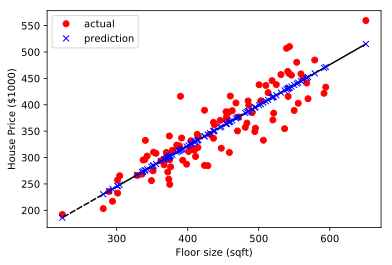

In [6]:
#ignore
plt.plot(sqft, price/1000, 'ro', label='actual')
plt.plot(sqft, price_predict/1000,'k--')

plt.plot(sqft, price_predict/1000, 'bx', label='prediction')
plt.ylabel('House Price ($1000)')
plt.xlabel('Floor size (sqft)')
plt.legend();

Our model has done what we wanted -- given a number of square feet in a house, we can predict its price. What we _don't_ have yet is an estimate of the uncertainty in the estimate.

#### Why we cannot just use residual standard deviation

Because we generated this data, we know that we started with a linear relationship and then added noise with a standard deviation of 35k to each point. What happens if we look at the standard deviation in the predictions? Do we get close to 35k?

In [7]:
residual = price - price_predict
print(f'The standard deviation in residuals is ${np.std(residual):4.2f}')

The standard deviation in residuals is $32106.40


This doesn't seem to be too bad of an estimate! 


Even though this dataset was generated with a standard error of $\pm 15$k, because the slope was estimated incorrectly, the errors in our predictions get worse as we move to very small or very large houses. This is even true in the ideal case (where we know the linear modeling assumptions are correct).

### Bootstrap

Because this is a simulation, we could simlate another 100 data points and see what they would give us for the slope and intercept. However, we generally cannot just retake our data; instead we have the dataset we started with. Bootstrapping makes new data by resampling the old data set.

In [8]:
def linear_resample(X_train, y_train):
    """Resample a single time, and return the coef and intercept"""
    # Sample the rows, ensure that X_train is a DataFrame
    # and not a numpy array
    X_sample = pd.DataFrame(X_train).sample(len(X_train), replace=True)
    # Make sure we grab the _corresponding_ rows in y_train
    y_sample = pd.DataFrame(y_train).loc[X_sample.index]
    # model problem
    model = LinearRegression().fit(X_sample, y_sample)
    return (model.coef_[0][0], model.intercept_[0])

def report_slope_and_intercept(X_train=sqft, y_train=price):
    slope, intercept = linear_resample(X_train, y_train)
    return f'The slope found is ${slope:6.2f}/sqft, and the intercept found is ${intercept:6.2f}'

Let's run this function 5 times, and see how the slope and intercept vary:

In [9]:
#ignore
for _ in range(5):
    print(report_slope_and_intercept())

The slope found is $705.71/sqft, and the intercept found is $45121.77
The slope found is $730.18/sqft, and the intercept found is $29849.39
The slope found is $806.49/sqft, and the intercept found is $-4657.18
The slope found is $767.05/sqft, and the intercept found is $15434.99
The slope found is $789.70/sqft, and the intercept found is $6308.44


We are generating the points using the same code, but the examples we are looking at happen to change. We have some idea what the sensitivity of our model to the sample we picked. Let's do this a _lot_ of times, and look at the distribution of slopes and intercepts. The true values used for generating the data are shown as dotted lines.

In [10]:
slopes, intercepts = [], []
for _ in range(1000):
    slope, intercept = linear_resample(sqft, price)
    slopes.append(slope)
    intercepts.append(intercept)

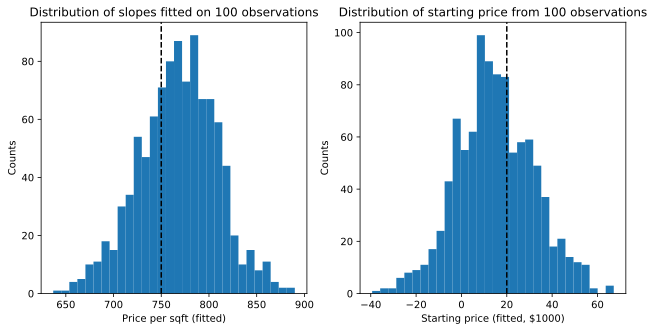

In [11]:
#ignore
plt.figure(figsize=(10.5,5))
plt.subplot(1,2,1)
plt.hist(slopes, bins=30);
plt.xlabel('Price per sqft (fitted)')
plt.ylabel('Counts')
plt.title('Distribution of slopes fitted on 100 observations')
plt.axvline(750, c='k', ls='--');

plt.subplot(1,2,2)
plt.hist(np.array(intercepts)/1000, bins=30);
plt.xlabel('Starting price (fitted, $1000)')
plt.ylabel('Counts')
plt.title('Distribution of starting price from 100 observations')
plt.axvline(20, c='k', ls='--');


We could look at confidence intervals on these distributions,  this will give us an estimate of the slope _and its error_, as well as the intercept _and its error_. If we wanted 95% CI, we could write a short function:

In [12]:
def get_ci(values, ci=0.95):
    lower_percentile = (1-ci)/2
    upper_percentile = ci + lower_percentile
    lower_index = int(np.floor(lower_percentile*len(values)))
    upper_index = int(np.ceil(upper_percentile*len(values)))
    sorted_values = sorted(values)
    return sorted_values[lower_index], sorted_values[upper_index]

get_ci(slopes)

(683.1384684757704, 849.1109354135815)


We can also make predictions by asking each of our models to make independent predictions. Different models will give different predictions, so we might think that we can estimate our uncertainty in our predictions this way. Trying it out:

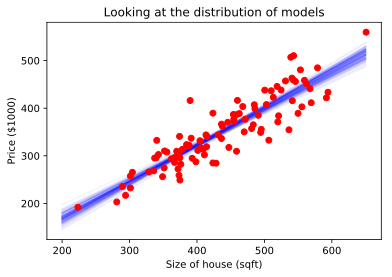

In [13]:
#ignore
to_draw=120
for m, b in zip(slopes[:to_draw], intercepts[:to_draw]):
    plt.plot([200, 650], [(200*m + b)/1000, (650*m+b)/1000], 'b-', alpha=0.05)

plt.plot(sqft, price/1000, 'ro', label='actual')
plt.xlabel('Size of house (sqft)');
plt.ylabel('Price ($1000)')
plt.title('Looking at the distribution of models');

We see the predictions of the different models (in blue) show some uncertainty, but nowhere near the actual scatter in the data.

The reason this reasonable sounding approach doesn't work is bootstrapping only allows us to estimate how different samples influcence the parameters. As an extreme example, suppose we had so much data that we found the slope and intercept with very low uncertainties, and got:
$$\text{price} = 750\times(\text{square feet}) + 20000$$
This is _almost_ the formula used to generate the data in the first place. The piece that is missing if the $\pm 35$k in noise we included. There is no way for our linear regression to capture this noise (it is sometimes called "irreducible noise"). The resampling only estimates estimates the effect of sampling leading us to slightly wrong population parameters. A reasonable way of combining the sampling error and irreducible noise is
$$\text{estimated error} = \sqrt{\text{(sampling error)}^2 + \text{(irreducible error)}^2}$$


### Quick summary of boostrap:

* It is used to estimate how sensitive our parameters are to our particular sample
* We can give a good description of the uncertainty in our parameter
* It can be useful to plot the predictions of the different models to get an idea of the sampling error ....
* .... but plotting the different model predictions doesn't account for the irreducible error
* We will see (later in the article) how to give predictions error bars.

## Build a Better Bootstrap

Let's write a manual bootstrapping function where we tell it what type of model we want to bootstrap (e.g. `LinearRegression`, `SVM`, etc), how many times we want to bootstrap, and the data we want it to resample from:

In [14]:
from copy import deepcopy

def fit_bootstrap(base_model, n_bootstrap, X_train, y_train):
    """
    Fits n_bootstrap different copies of base_model, using 
    samples with replacement on X_train and y_train.
    
    Returns a list of models
    """
    models = []
    # ensure we have dataframes, not numpy arrays
    X_train, y_train= pd.DataFrame(X_train), pd.DataFrame(y_train)
    for _ in range(n_bootstrap):
        X_sample = X_train.sample(len(X_train), replace=True)
        y_sample = y_train.loc[X_sample.index]
        models.append(deepcopy(base_model).fit(X_sample, y_sample))
    return models

Let's see it in action, and get the distribution of slopes from our data:

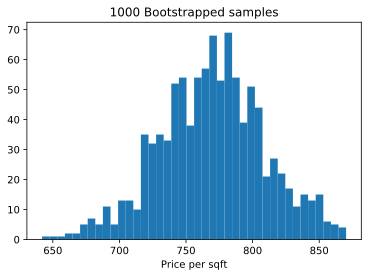

In [15]:
models = fit_bootstrap(LinearRegression(), 1000, sqft, price)
plt.hist([m.coef_[0][0] for m in models], bins=40)
plt.xlabel('Price per sqft')
plt.title('1000 Bootstrapped samples');

We can also ask for a distribution of what the different models predict for a house price:

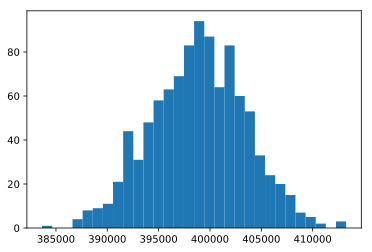

In [19]:
plt.hist([m.predict([[500]])[0][0] for m in models], bins=30);

We should remember when doing this, we are only capturing the _sampling_ error. The irreducible error, and any modeling error have not been included. 

Now that we understand how to make our own Bootstrap

In [17]:
from sklearn.ensemble import BaggingRegressor

bag = BaggingRegressor(base_estimator=LinearRegression(), bootstrap=True).fit(sqft, price.reshape(-1))

In [18]:
bag.estimators_

[LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False)]